# Automatic detection of tweek atmospherics in radio spectrograms based on deep learning approach

---


## Authors
**V. Maslej-Krešňáková $^1$, A. Kundrát $^1$, Š. Mackovjak $^2$, P. Butka $^2$, S. Jaščur $^1$, I. Kolmašová $^{3,4}$, O. Santolík $^{3,4}$**


$^1$  Department of Cybernetics and Artificial Intelligence, Faculty of Electrical Engineering and Informatics, Technical University of Košice, Košice, Slovakia

$^2$   Department of Space Physics, Institute of Experimental Physics, Slovak Academy of Sciences, Košice, Slovakia

$^3$   Department of Space Physics, Institute of Atmospheric Physics of the Czech Academy of Sciences, Prague, Czechia

$^4$   Faculty of Mathematics and Physics, Charles University, Prague, Czechia


## Abstract

Lightning strikes can be routinely observed by the radio receivers that measure electromagnetic signals in the very low frequency (VLF) range. The acquired pulses called atmospherics provide valuable details about source lightning discharges and also about the Earth-ionosphere waveguide where they can propagate thousands of kilometers. The automatic acquisition of the events requires also automatic methods for extraction of atmospherics' details to confirm the observed trends with statistical significance. For this purpose, we have developed a method based on a deep learning approach to automatically obtain the type of atmospherics, their exact time, and the frequency range from the frequency-time spectrograms. The method that employs convolutional neural networks is designed to be adaptable to scientific needs and provide reliable results according to the requirements on the sensitivity to events, computation performance, and precision of extracted details. The comprehensive description of the method allows its usage for regular characterization of the ionospheric D-layer or for other similar applications in the future.

---


## Python notebook 
In the following, we present the data and Python methods used for analysis presented in the article. Here is an overview of the python notebook:
1. Environment set-up
2. Data preprocessing
3. Deep learning approach
4. Deterministic approach
4. Results 

# 1. Environment set-up

In [ ]:
import os
import sys
#!git clone https://github.com/space-lab-sk/tweeks_detection
#%cd tweeks_detection
#!git pull origin main 
!pip install -r requirements.txt
!conda install -c conda-forge poppler -y

* Import libraries

In [ ]:
import PyPDF2
import os
import tempfile
import zipfile,fnmatch
import csv
import pandas as pd
import numpy as np
import json
import math 
import cv2
import operator
from PIL import Image, ImageDraw
import operator
from skimage.io import imread
from PyPDF2 import PdfFileWriter, PdfFileReader
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from PIL import Image
import sklearn.metrics

# 2. Data preprocessing

* Unzip data

In [16]:
rootPath = r"files/zip_from_web"

In [17]:
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))
        os.remove(os.path.join(root, filename))

for root, dirs, files in os.walk(rootPath):
    for file in files:
        if file.endswith(".pdf")==False:
            os.remove(os.path.join(root, file))

* Crop images and extract informations from pdf

*Sample of one page from pdf provided by the initial processing of ELMAVAN-G instrument. Our primary focus is on the bottom of the page, which contains a spectrogram for every channel. Every spectrogram displays one second of the measured interval (144 s) with the strongest emission. In preprocessing phase, we cropped spectrograms from Channel 2 and used them to train our models. The parsing of textual data in pdf helped us obtain the exact second of the beginning of the whole measurement (number after the decimal point in text related to date and time -- 199) and the precise second (within 144s) recorded in this particular page (62).*


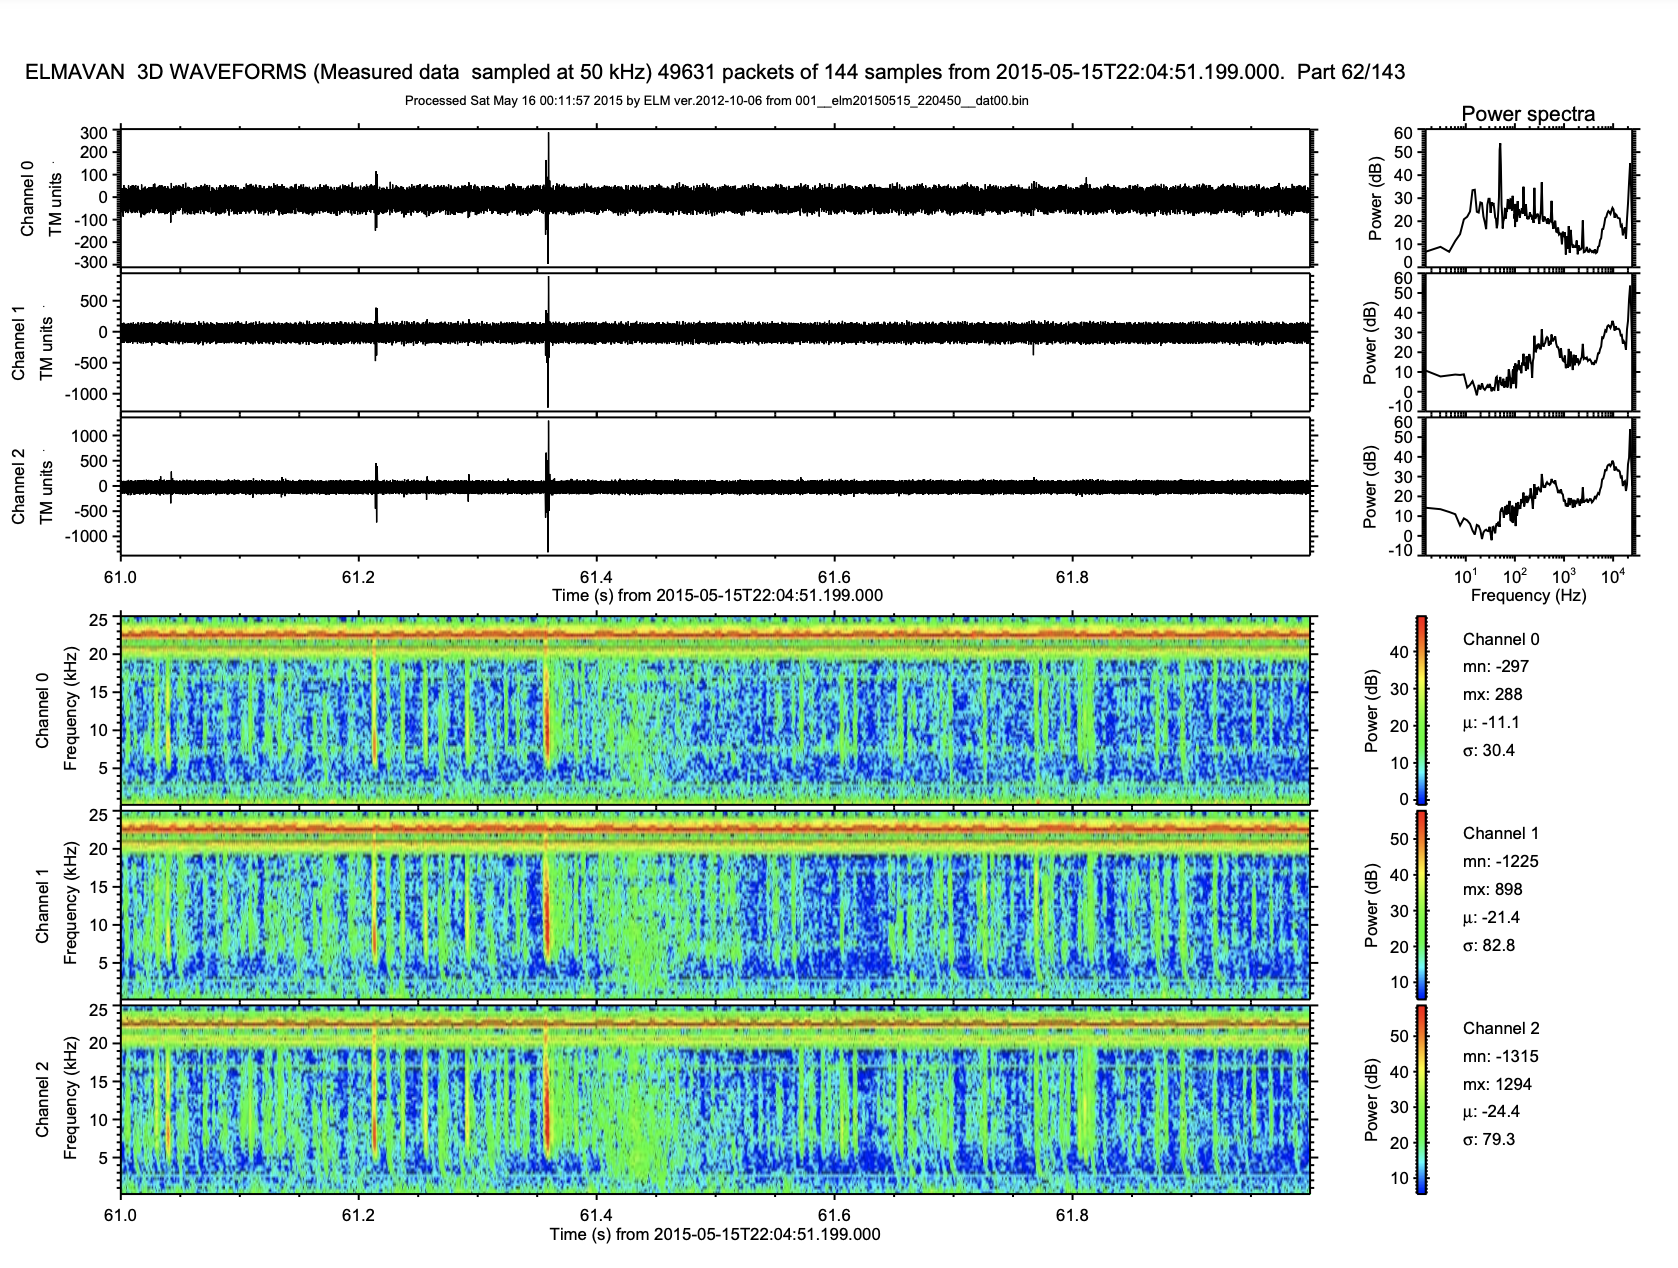

In [18]:
# parameters to crop images (in pixels)
left = 154
upper = 1392
right = 1575
lower = 1554

In [19]:
# crop and save 9 images from one pdf in form "ch2_20150515_220451_199_s37.jpg"
for root, dirs, files in os.walk(rootPath):
    graphMetaData=[]
    for file in files:
        if file.endswith(".pdf"):
            print("####################################")
            print("processing %s" %root)
            graphMetaData=[]
            pdfFileObj = open(os.path.join(root, file), 'rb')
            pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
            pageObjDate = pdfReader.getPage(0)
            textDate=pageObjDate.extractText()
            if "from " in textDate:
                dateOfGraph=textDate[textDate.find('from ')+5:textDate.find('from ')+29]
            else: 
                print("pdf from %s is empty, lets continue")
                break
            dateOfGraph=dateOfGraph.replace("-", "")
            dateOfGraph=dateOfGraph.replace("T", "_")
            dateOfGraph=dateOfGraph.replace(".", "_", 1)
            dateOfGraph=dateOfGraph.replace(".", "")
            dateOfGraph=dateOfGraph.replace(":", "")
            for j in range(pdfReader.numPages):
                pageObj = pdfReader.getPage(j)
                text=pageObj.extractText()
                if "Part" in text:
                    graphMetaData.append(text[text.find('Part')+5:text.find('/')])
                else:
                    graphMetaData.append(0)

            with tempfile.TemporaryDirectory() as path:
                images_from_path = convert_from_path(os.path.join(root, file), output_folder=path)

            orderNr=0
            for page in images_from_path:
                page.save(os.path.join(root,"%s. %s.jpg" % (orderNr, graphMetaData[orderNr])), 'JPEG')   
                orderNr+=1

            os.remove(os.path.join(root, "0. 0.jpg"))
            os.remove(os.path.join(root, "%s. %s.jpg" % (orderNr-1, graphMetaData[orderNr-1])))
            graphMetaData.remove(graphMetaData[0])
            graphMetaData.remove(graphMetaData[orderNr-2])
            for item in graphMetaData:
                im = Image.open(os.path.join(root, "%s. %s.jpg" % (str(graphMetaData.index(item)+1), item)))
                im.crop((left, upper, right, lower)).save(os.path.join(root, "ch2_%s_s%s.jpg"%(dateOfGraph, item)))
                os.remove(os.path.join(root, "%s. %s.jpg" % (str(graphMetaData.index(item)+1), item)))
            os.remove(os.path.join(root, "data.pdf"))
        else:
            continue

####################################
processing files/zip_from_web/elm_20150515_220450_pics
####################################
processing files/zip_from_web/elm_20150515_200446_pics


# 3. Deep learning approach

First we need to clone the yolov5 repository:

In [ ]:
!git clone https://github.com/ultralytics/yolov5

### Training YOLOv5 network

Train the model - uncomment the following code and train the model just if the satisfactory computational power is available (training took approx. 3 hours by using GPU Quadro RTX 4000)

Arguments:
* *img*: input width (in pixels) <br>
* *rect*: rectangular training <br>
* *batch*: total batch size for all GPUs <br>
* *epochs*: <br>
* *data*: dataset.yaml path <br>
* *cfg*: path to YOLOv5s.yaml version model <br>
* *weights*: empty - we didn't use pre-trained weights  <br>

In [ ]:
#!python yolov5/train.py --img 1184 --rect --batch 4 --epochs 400 --data files/data/events.yaml --cfg yolov5/models/yolov5s.yaml --weights '' --device 0

### Detection on test set

Argumnets:
* *source*: test data <br>
* *weights*: path to saved model.pt <br>
* *iou*: NMS IoU threshold <br>
* *conf*: confidence threshold <br>
* *img*: input width <br>
* *save-txt*: save results to *.txt
* *save-conf*: save confidences in --save-txt labels

In [ ]:
!python yolov5/detect.py --weights runs/train/exp/weights/best.pt --source files/test_img --iou 0.45 --conf 0.3 --img 1184 --save-txt --save-conf

*Example of a cropped spectrogram image, which is ready as an input for the training of our neural network model*

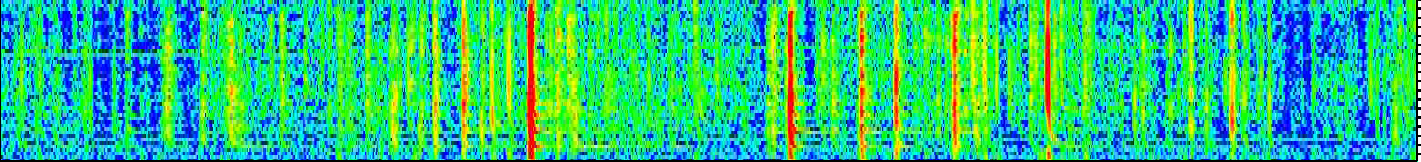 

# 4. Deterministic approach

We used predictions from the YOLO network for two purposes – to provide basic information in the output table with detected events and as input for tasks to extract additional features about events. The output data table with detected events contains columns *date* and *second* extracted from the part of the jpg file name. We created column *tweek* based on the neural network's output, which represents binary value whether the event is tweek (1) or spheric (0). For the detection of the precise time of event and occurrence of their emission under 2kHz, it was necessary to use post-processing to obtain columns *millisecond* and *f\_min<2kHz*. In both cases, we worked only with the red channel of the image for the decision.

*f_min<2kHz:<br>
Example of an event that does not reach below 2 kHz. <br>
The black horizontal line represents the border for the algorithm to evaluate if events have an emission under 2 kHz.*

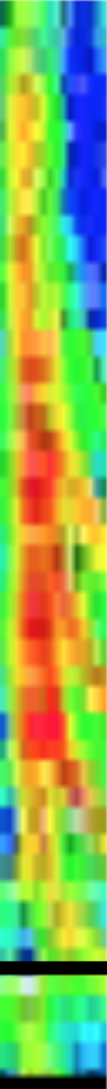 


*Milisecond: <br>
An example of the event with the column of pixels representing the highest red value (black line) <br>
– extracted time of the event* 

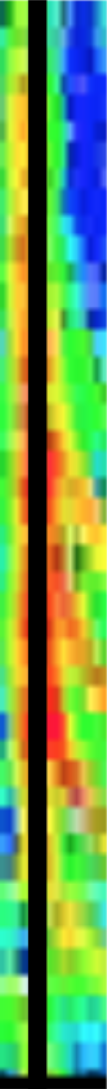

In [20]:
# set paths
imagePath="files/test_img"
route="exp"
rootPath = r"runs/detect/" + route + "/labels"
path = "files"

In [21]:
imageNR=1
with open(os.path.join(path, "output" + route + ".csv"), "w") as outputCsv:    
    fieldnamesOutput = ['image','event', 'date', 'second', 'milisecond', 'tweek', 'f_min<2kHz', 'confidence']
    tableWriter = csv.DictWriter(outputCsv, fieldnames=fieldnamesOutput, delimiter=',')
    tableWriter.writeheader()
    
    for root, dirs, files in os.walk(rootPath):
        for file in files:
            with open(os.path.join(root, file), "r") as csv_file:
                reader = csv.reader(csv_file, delimiter=' ')
                sortedlist = sorted(reader, key=operator.itemgetter(1))
            with open(os.path.join(root, file), "w") as csv_file1:
                writer = csv.writer(csv_file1, delimiter=' ')
                writer.writerows(sortedlist)

            with open(os.path.join(root, file), "r") as coordFile:

                fieldnamesCoords = ['label','x', 'y', 'width', 'height', 'conf']
                eventNR=1
                coordReader = csv.DictReader(coordFile, fieldnames=fieldnamesCoords, delimiter=' ')
                try:
                    img = Image.open(os.path.join(imagePath, file.split(".")[0]+".jpg"))
                except:
                    break
                w, h = img.size
                widthms=w/1000

                for row in coordReader:
                    widthCoord=round(float(row['width'])*w)
                    xCoord=round((float(row['x'])*w)-(float(widthCoord)/2))
                    im = img.crop((xCoord, 0, xCoord+widthCoord, 162)).save(os.path.join(root, "1.jpg"))
                    red = imread(os.path.join(root, "1.jpg"))[:, :, 0]
                    os.remove(os.path.join(root, "1.jpg"))

                    red=np.delete(red,len(red)-1,0)
                    red=np.delete(red,len(red)-1,0)

                    transposered=np.transpose(red)
                    
                    #milisecond
                    middle=0
                    indexOfMid=0
                    currentIndex=1
                    for i in transposered:
                        if sum(i) > middle:
                            middle=sum(i)
                            indexOfMid=currentIndex
                        currentIndex+=1

                    milsec=round((indexOfMid+xCoord)/widthms)
                    
                    #f_min<2kHz
                    j=0
                    wholeImg=0
                    endImg=0
                    while(j<160):
                        wholeImg+=sum(red[j])
                        if j>138:
                            endImg+=sum(red[j])

                        j+=1

                    if (float((endImg*100)/wholeImg))>9.5:
                        result=1
                    else: result=0
                        
                    #create table    
                    tableWriter.writerow({
                        'image':imageNR, 
                        'event':eventNR, 
                        'date':file[4:19], 
                        'second':file[file.find("s")+1:file.find(".txt")], 
                        'milisecond':milsec, 
                        'tweek':row['label'], 
                        'f_min<2kHz':result,
                        'confidence':round(float(row['conf']),3)})
                    eventNR+=1
                    # print(row)

                imageNR+=1

In [22]:
pd.read_csv('files/outputexp.csv')

,image,event,date,second,milisecond,tweek,f_min<2kHz,confidence
0,1,1,20150902_230932,93,128,0,1,0.472
1,1,2,20150902_230932,93,128,1,1,0.386
2,1,3,20150902_230932,93,271,0,0,0.662
3,1,4,20150902_230932,93,350,0,1,0.603
4,1,5,20150902_230932,93,458,0,0,0.313
...,...,...,...,...,...,...,...,...
2098,218,8,20180607_195716,91,403,0,1,0.679
2099,218,9,20180607_195716,91,460,0,0,0.516
2100,218,10,20180607_195716,91,527,0,0,0.555
2101,218,11,20180607_195716,91,928,0,0,0.732


# 5. Evaluation

In [23]:
# As we have a threshold less than 0.5, it can happen that one event will be marked as tweek and at the same time as spheric. 
# In this case, we will leave only the record Tweek (in most cases, the tweek has a higher confidence value as spheric).

def clear_duplicate(df):
    mil=[]
    tweek=[]
    for i in df['milisecond']:
        mil.append(i)

    for i in df['tweek']:
        tweek.append(i)

    for index, elem in enumerate(mil):
        if (index+1 <= len(mil) and index - 1 >= 0):
            prev_el = str(mil[index-1])
            curr_el = str(elem)
            if prev_el == curr_el:
                if tweek[index]>tweek[index-1]:
                    df=df.drop(df.index[index-1])
                    mil.pop(index-1)
                    tweek.pop(index-1)
                else:
                    df=df.drop(df.index[index])
                    mil.pop(index)
                    tweek.pop(index)
    return df


## 5.1 Results - detection of events

In [24]:
# read prediction and anotations obtained from manual marking
dfPred = pd.read_csv("files/outputexp.csv")
dfAnot = pd.read_csv("files/outputAnot.csv")

# clear duplicate in prediction
dfPred = clear_duplicate(dfPred)

# group by date
gPred = dfPred.groupby('date')
gAnot = dfAnot.groupby('date')

arrPred=[]
arrAnot=[]
predBackground=[]
anotBackground=[]

for group_name, df_group in gPred:
    for row_index, row in df_group.iterrows():
        arrPred.append([row['date'], row['milisecond'], row['tweek']])
        predBackground.append([row['date'], row['milisecond']])

for group_name, df_group in gAnot:
    for row_index, row in df_group.iterrows():
        arrAnot.append([row['date'], row['milisecond'], row['tweek']])
        anotBackground.append([row['date'], row['milisecond']])
 

# create the confusion matrix -- comparison of predictions and annotations 
arrPred2=[]
arrAnot2=[]

TP=0   
TN=0 
for i in arrPred:
    if i in arrAnot:
        if i[2]==0:
            TP+=1 
        elif i[2]==1:
            TN+=1
    else:
        arrPred2.append(i)

TPanot=0   
TNanot=0
for i in arrAnot:
    if i in arrPred2:
        if i[2]==0:
            TPanot+=1
        elif i[2]==1:
            TNanot+=1
    else:
        arrAnot2.append(i)

FN=0 
FP=0 
for i in arrPred2:
    j=i
    if j[2]==0:
        j[2]=1
        if j in arrAnot2:
            FP+=1
    elif j[2]==1: 
        j[2]=0
        if j in arrAnot2:
            FN+=1   
            
BFP1=0 
BFP2=0 
for i in predBackground:
    if i not in anotBackground:
        if arrPred[predBackground.index(i)][2] == 1:
            BFP1+=1
        else:
            BFP2+=1
            
BFN1=0 
BFN2=0 
for i in anotBackground:
    if i not in predBackground:
        if arrAnot[anotBackground.index(i)][2] == 1:
            BFN2+=1
        else:
            BFN1+=1

# evaluation
precision_sferic = TP/(TP+FP+BFP1)
precision_tweek = TN/(TN+FN+BFP2)

print("Precision for class sferic is", str(round(precision_sferic, 2)))
print("Precision for class tweek is", str(round(precision_tweek, 2)))

recall_sferic = TP/(TP+FN+BFN1)
recall_tweek = TN/(TN+FP+BFN2)

print("Recall for class sferic is", str(round(recall_sferic, 2)))
print("Recall for class tweek is", str(round(recall_tweek, 2)))

f1_sferic = 2*(precision_sferic*recall_sferic/(precision_sferic+recall_sferic))
f1_tweek = 2*(precision_tweek*recall_tweek/(precision_tweek+recall_tweek))

print("F1 score for class sferic is", str(round(f1_sferic, 2)))
print("F1 score for class tweek is", str(round(f1_tweek, 2)))

Precision for class sferic is 0.74
Precision for class tweek is 0.58
Recall for class sferic is 0.68
Recall for class tweek is 0.57
F1 score for class sferic is 0.71
F1 score for class tweek is 0.57


## 5.2 Results - identification of emission below or over 2 kHz

In [25]:
# read prediction and anotations obtained from manual marking of events below 2 over 2 kHz
df_pred = pd.read_csv('files/outputexp.csv')
df_annot = pd.read_csv('files/anotation_f_min_2kHz.csv')
df_pred = pd.DataFrame(df_pred)
df_annot = pd.DataFrame(df_annot)
df_annot = df_annot[df_annot.date != 'txt']

# drop
df_annot.drop(['Unnamed: 0', 'image', 'event'], axis='columns', inplace=True)
df_pred.drop(['image','event', 'confidence'], axis='columns', inplace=True)

# clear duplicate                
df_pred=clear_duplicate(df_pred)
df_annot=clear_duplicate(df_annot)

# retype object to integer before merge
df_pred['date']=df_pred['date'].astype(int)
df_annot['date']=df_annot['date'].astype(int)
df_annot['second']=df_annot['second'].astype(int)

# merge dataset
df_inner = df_annot.merge(df_pred,  how='inner', on = ['date', 'second', 'milisecond'])

# evaluation
y_true = df_inner['f_min<2kHz_TRUE']
y_pred = df_inner['f_min<2kHz_x']

print(sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None))
print(sklearn.metrics.classification_report(y_true, y_pred))

[[1011   42]
 [  79  835]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1053
           1       0.95      0.91      0.93       914

    accuracy                           0.94      1967
   macro avg       0.94      0.94      0.94      1967
weighted avg       0.94      0.94      0.94      1967

